# 数据类别不均衡处理

在可视化环节中，我们观察到正负样本的比例大概在1:3左右，因此需要对正样本进行升采样或对负样本进行降采样。考虑到本数据集仅有7千多条样本，不适合采用降采样，进行升采样更为合理，本案例采用升采样中较为成熟的SMOTE方法生成更多的正样本。
- 参考链接：https://blog.csdn.net/Yaphat/article/details/52463304

In [12]:
import time 
import random
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors    # k近邻算法

In [13]:
# 设置忽略警告
import warnings
warnings.filterwarnings('ignore')

#显示所有列
pd.set_option('display.max_columns', None)
#显示所有行
pd.set_option('display.max_rows', None)

### 设置不使用科学计数法  #为了直观的显示数字，不采用科学计数法
np.set_printoptions(precision=3, suppress=True)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [14]:
# 加载前面处理好的数据
data = pd.read_csv("./processed_data/processed_data.csv")
print(data.shape)
print(data["Churn"].value_counts())
data.head()

(7043, 22)
0    5174
1    1869
Name: Churn, dtype: int64


,SeniorCitizen,Partner,Dependents,tenure,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,PaperlessBilling,MonthlyCharges,InternetService_DSL,InternetService_Fiber optic,InternetService_No,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn
0,0,1,0,-1.28,0,0,1,0,0,1,-1.16,1,0,0,1,0,0,0,0,1,0,0
1,0,0,0,0.07,0,1,0,1,0,0,-0.26,1,0,0,0,1,0,0,0,0,1,0
2,0,0,0,-1.24,0,1,1,0,0,1,-0.36,1,0,0,1,0,0,0,0,0,1,1
3,0,0,0,0.51,0,1,0,1,1,0,-0.75,1,0,0,0,1,0,1,0,0,0,0
4,0,0,0,-1.24,0,0,0,0,0,1,0.20,0,1,0,1,0,0,0,0,1,0,1


In [15]:
# 定义Smote类
class Smote:
    def __init__(self,samples,N,k):
        self.n_samples,self.n_attrs=samples.shape
        self.N=N
        self.k=k
        self.samples=samples
        self.newindex=0

    def over_sampling(self):
        N=int(self.N)
        self.synthetic = np.zeros((self.n_samples * N, self.n_attrs))
        neighbors=NearestNeighbors(n_neighbors=self.k).fit(self.samples)    # 1.对每个少数类样本均求其在所有少数类样本中的k近邻
        for i in range(len(self.samples)):
            nnarray=neighbors.kneighbors(self.samples[i].reshape(1,-1),return_distance=False)[0]
            self._populate(N,i,nnarray)
        return self.synthetic

    # 2.为每个少数类样本选择k个最近邻中的N个；3.并生成N个合成样本
    def _populate(self,N,i,nnarray):
        for j in range(N):
            nn=random.randint(0,self.k-1)
            dif=self.samples[nnarray[nn]]-self.samples[i]
            gap=random.random()
            self.synthetic[self.newindex]=self.samples[i]+gap*dif
            self.newindex+=1

In [16]:
# 每个正样本用SMOTE方法随机生成两个新的样本
posDf = data[data['Churn'] == 1].drop(['Churn'], axis=1)    # 共1869条正样本, 取其所有特征列
posArray = posDf.values    # pd.DataFrame -> np.array, 以满足SMOTE方法的输入要求
newPosArray = Smote(posArray, 2, 5).over_sampling()
newPosDf = pd.DataFrame(newPosArray)    # np.array -> pd.DataFrame
print(newPosDf.shape)

(3738, 21)


In [17]:
newPosDf.head(10)  # 观察此时的新样本

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,0.00,0.00,0.00,-1.21,0.00,1.00,1.00,0.00,0.00,1.00,-0.77,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00
1,0.00,0.00,0.00,-1.24,0.00,0.18,1.00,0.00,0.00,1.00,-0.48,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00
2,0.00,0.00,0.00,-1.24,0.00,0.00,0.00,0.00,0.00,1.00,0.20,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00
3,0.00,0.00,0.00,-1.26,0.00,0.00,0.00,0.00,0.00,1.00,0.20,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00
4,0.00,0.00,0.00,-0.97,1.00,0.00,0.00,1.00,0.00,1.00,1.17,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00
5,0.00,0.00,0.00,-0.99,1.00,0.00,0.00,1.00,0.00,1.00,1.16,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00
6,0.00,1.00,0.62,-0.10,1.00,0.00,0.00,1.00,1.00,1.00,1.32,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00
7,0.00,1.00,0.00,0.05,1.00,0.00,0.00,1.00,1.00,1.00,1.05,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00
8,0.59,0.00,0.00,0.51,1.00,0.00,1.00,1.00,0.00,1.00,1.31,0.00,1.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00
9,0.00,0.00,0.00,0.68,1.00,0.00,1.00,1.00,0.00,1.00,1.30,0.00,1.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00


In [18]:
newPosDf.tail(10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
3728,0.00,0.00,0.00,-0.86,0.00,0.00,0.00,0.00,1.00,1.00,-0.20,1.00,0.00,0.00,0.10,0.90,0.00,0.00,0.00,1.00,0.00
3729,0.00,0.00,0.00,-1.27,0.00,0.00,0.00,0.00,1.00,1.00,-0.46,1.00,0.00,0.00,0.99,0.01,0.00,0.00,0.00,1.00,0.00
3730,0.00,0.00,0.00,-0.95,0.00,0.00,0.00,0.00,0.00,1.00,-0.68,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00
3731,0.00,0.00,0.00,-1.21,0.00,0.00,0.00,0.00,0.00,1.00,-0.67,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00
3732,1.00,0.00,0.00,-1.28,1.00,0.00,0.00,0.00,0.00,1.00,0.37,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00
3733,1.00,0.00,0.00,-1.28,1.00,0.00,0.00,0.00,0.00,1.00,0.37,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00
3734,0.00,0.00,0.00,0.89,0.56,1.00,1.00,1.00,0.00,1.00,0.99,0.00,1.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00
3735,0.00,0.00,0.00,1.05,1.00,0.67,1.00,1.00,0.00,1.00,1.29,0.00,1.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00
3736,1.00,1.00,0.00,-1.16,1.00,0.00,0.00,0.00,0.00,1.00,0.32,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00
3737,1.00,1.00,0.00,-1.16,1.00,0.00,0.00,0.00,0.00,1.00,0.32,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00


In [19]:
# 调整为正样本在数据集中应有的格式
newPosDf.columns = posDf.columns    # 还原特征名
cateCols = list(newPosDf.columns.drop(['tenure', 'MonthlyCharges']))   # 提取离散特征名组成的列表
for i in cateCols:
    newPosDf[i] = newPosDf[i].apply(lambda x: 1 if x >= 0.5 else 0)    # 将特征值变回0、1二元数值
newPosDf['Churn'] = 1    # 添加目标变量列
print(newPosDf.shape)
newPosDf.head(10)    # 观察此时的新样本

(3738, 22)


,SeniorCitizen,Partner,Dependents,tenure,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,PaperlessBilling,MonthlyCharges,InternetService_DSL,InternetService_Fiber optic,InternetService_No,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn
0,0,0,0,-1.21,0,1,1,0,0,1,-0.77,1,0,0,1,0,0,0,0,0,1,1
1,0,0,0,-1.24,0,0,1,0,0,1,-0.48,1,0,0,1,0,0,0,0,0,1,1
2,0,0,0,-1.24,0,0,0,0,0,1,0.20,0,1,0,1,0,0,0,0,1,0,1
3,0,0,0,-1.26,0,0,0,0,0,1,0.20,0,1,0,1,0,0,0,0,1,0,1
4,0,0,0,-0.97,1,0,0,1,0,1,1.17,0,1,0,1,0,0,0,0,1,0,1
5,0,0,0,-0.99,1,0,0,1,0,1,1.16,0,1,0,1,0,0,0,0,1,0,1
6,0,1,1,-0.10,1,0,0,1,1,1,1.32,0,1,0,1,0,0,0,0,1,0,1
7,0,1,0,0.05,1,0,0,1,1,1,1.05,0,1,0,1,0,0,0,0,1,0,1
8,1,0,0,0.51,1,0,1,1,0,1,1.31,0,1,0,1,0,0,1,0,0,0,1
9,0,0,0,0.68,1,0,1,1,0,1,1.30,0,1,0,1,0,0,1,0,0,0,1


In [20]:
print("原本的正样本有%d条" % posDf.shape[0])
print("原本的负样本有%d条" % (data.shape[0] - posDf.shape[0]))

原本的正样本有1869条
原本的负样本有5174条


In [21]:
# 为保证正负样本平衡，从新生成的样本中取出（5174 - 1869 = 3305）条样本，并加入原数据集进行shuffle操作。

# 构建类别平衡的数据集
from sklearn.utils import shuffle    

# newPosDf = newPosDf[:3305]    # 直接选取前3305条样本
newPosDf = newPosDf.sample(n=3305) # 随机抽取3305条样本
data = pd.concat([data, newPosDf])    # 竖向拼接
data = shuffle(data).reset_index(drop=True) # 样本打乱
print(data["Churn"].value_counts())
print("此时数据集的规模为：", data.shape)
data.to_csv("./processed_data/processed_smote.csv",index=False)
data.head()

0    5174
1    5174
Name: Churn, dtype: int64
此时数据集的规模为： (10348, 22)


,SeniorCitizen,Partner,Dependents,tenure,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,PaperlessBilling,MonthlyCharges,InternetService_DSL,InternetService_Fiber optic,InternetService_No,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn
0,0,0,1,0.15,0,0,1,0,0,1,1.00,0,1,0,1,0,0,0,0,1,0,0
1,1,1,0,-1.28,0,0,0,0,0,0,-0.66,1,0,0,1,0,0,0,0,1,0,1
2,0,0,0,-0.50,0,0,0,0,0,0,-1.50,0,0,1,0,1,0,0,0,0,1,0
3,0,0,0,0.80,0,0,1,0,0,1,0.68,0,1,0,1,0,0,0,0,1,0,1
4,0,1,0,1.61,1,1,1,0,0,1,0.64,0,1,0,0,0,1,1,0,0,0,0


# 模型选型与训练

- 我们使用逻辑回归、SVC、随机森林、LightGBM


In [22]:
from sklearn.linear_model import LogisticRegression as LR
from sklearn.svm import SVC as SVC
from sklearn.ensemble import RandomForestClassifier as RF
from lightgbm import LGBMClassifier as LGB  # pip install lightGBM

from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

- K折交叉验证

In [23]:
def kFold_cv(X, y, classifier, **kwargs):
    """
    :param X: 特征
    :param y: 目标变量
    :param classifier: 分类器
    :param **kwargs: 参数
    :return: 预测结果
    """
    kf = KFold(n_splits=5, shuffle=True) # 5折交叉验证
    y_pred = np.zeros(len(y))    # 初始化y_pred数组
    start = time.time()
    for train_index, test_index in kf.split(X):  
        X_train = X[train_index]    
        X_test = X[test_index]
        y_train = y[train_index]    # 划分数据集
        clf = classifier(**kwargs)    
        clf.fit(X_train, y_train)    # 模型训练
        y_pred[test_index] = clf.predict(X_test)    # 模型预测
    print("used time : {}".format(time.time()-start))
    return y_pred  

In [24]:
# 获取X,Y
# 加载数据
data = pd.read_csv("./processed_data/processed_smote.csv")
X = data.iloc[:,:-1]
Y = data.iloc[:,-1]
print(X.shape)
print(Y.shape)
print(data.head())


(10348, 21)
(10348,)
   SeniorCitizen  Partner  Dependents  tenure  MultipleLines  OnlineSecurity  \
0              0        0           1    0.15              0               0   
1              1        1           0   -1.28              0               0   
2              0        0           0   -0.50              0               0   
3              0        0           0    0.80              0               0   
4              0        1           0    1.61              1               1   

   OnlineBackup  DeviceProtection  TechSupport  PaperlessBilling  \
0             1                 0            0                 1   
1             0                 0            0                 0   
2             0                 0            0                 0   
3             1                 0            0                 1   
4             1                 0            0                 1   

   MonthlyCharges  InternetService_DSL  InternetService_Fiber optic  \
0            1.00 

In [25]:
x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size=0.2,random_state=1)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(8278, 21)
(2070, 21)
(8278,)
(2070,)


In [26]:
# 这里仅作演示的baseline，参数没仔细调，这里大家可以调完参数选择最优化模型进行训练/或者进行模型融合，再进行预测
# 进行K折交叉验证
lr_pred = kFold_cv(x_train.values,y_train.values,LR,penalty='l2',C=1.0)
svc_pred = kFold_cv(x_train.values,y_train.values,SVC,C=1.0)
rf_pred = kFold_cv(x_train.values,y_train.values, RF,n_estimators=100,max_depth=10)
lgb_pred = kFold_cv(x_train.values,y_train.values,LGB,learning_rate=0.1,n_estimators=1000,max_depth=10)


used time : 0.44161152839660645
used time : 10.095002889633179
used time : 2.003199577331543
used time : 5.866595029830933


In [27]:
scoreDf = pd.DataFrame(columns=['LR', 'SVC', 'RandomForest', 'LGB'])
pred = [lr_pred, svc_pred, rf_pred, lgb_pred]
for i in range(len(pred)):
    r = recall_score(y_train.values, pred[i])
    p = precision_score(y_train.values, pred[i])
    f1 = f1_score(y_train.values, pred[i])
    scoreDf.iloc[:, i] = pd.Series([r, p, f1])

scoreDf.index = ['Recall', 'Precision', 'F1-score']
scoreDf

,LR,SVC,RandomForest,LGB
Recall,0.80,0.81,0.87,0.85
Precision,0.75,0.75,0.77,0.81
F1-score,0.77,0.78,0.82,0.83


由上表可知，LGB模型效果最好，我们选择LGB模型单模型进行演示，并且输出其特征重要性

In [28]:
lgb = LGB(learning_rate=0.1,n_estimators=1000,max_depth=10)
lgb.fit(x_train,y_train)
y_train_pred = lgb.predict(x_train)
y_test_pred = lgb.predict(x_test)
print(classification_report(y_train,y_train_pred))
print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99      4131
           1       0.98      0.99      0.99      4147

    accuracy                           0.99      8278
   macro avg       0.99      0.99      0.99      8278
weighted avg       0.99      0.99      0.99      8278

              precision    recall  f1-score   support

           0       0.87      0.81      0.84      1043
           1       0.82      0.88      0.85      1027

    accuracy                           0.84      2070
   macro avg       0.84      0.84      0.84      2070
weighted avg       0.84      0.84      0.84      2070



In [29]:
# 特征重要度
feature_importances = lgb.feature_importances_
feature_importances

array([  617,  1077,   727,  9226,   694,   562,   678,   662,   559,
        1032, 10873,   151,   102,    29,   289,   368,   169,   416,
         444,   875,   433])

In [30]:
featurs_import_df = pd.DataFrame(X.columns,columns=['feature'])
featurs_import_df['importance'] = feature_importances
featurs_import_df

,feature,importance
0,SeniorCitizen,617
1,Partner,1077
2,Dependents,727
3,tenure,9226
4,MultipleLines,694
5,OnlineSecurity,562
6,OnlineBackup,678
7,DeviceProtection,662
8,TechSupport,559
9,PaperlessBilling,1032


In [31]:
import matplotlib.pyplot as plt
import lightgbm 

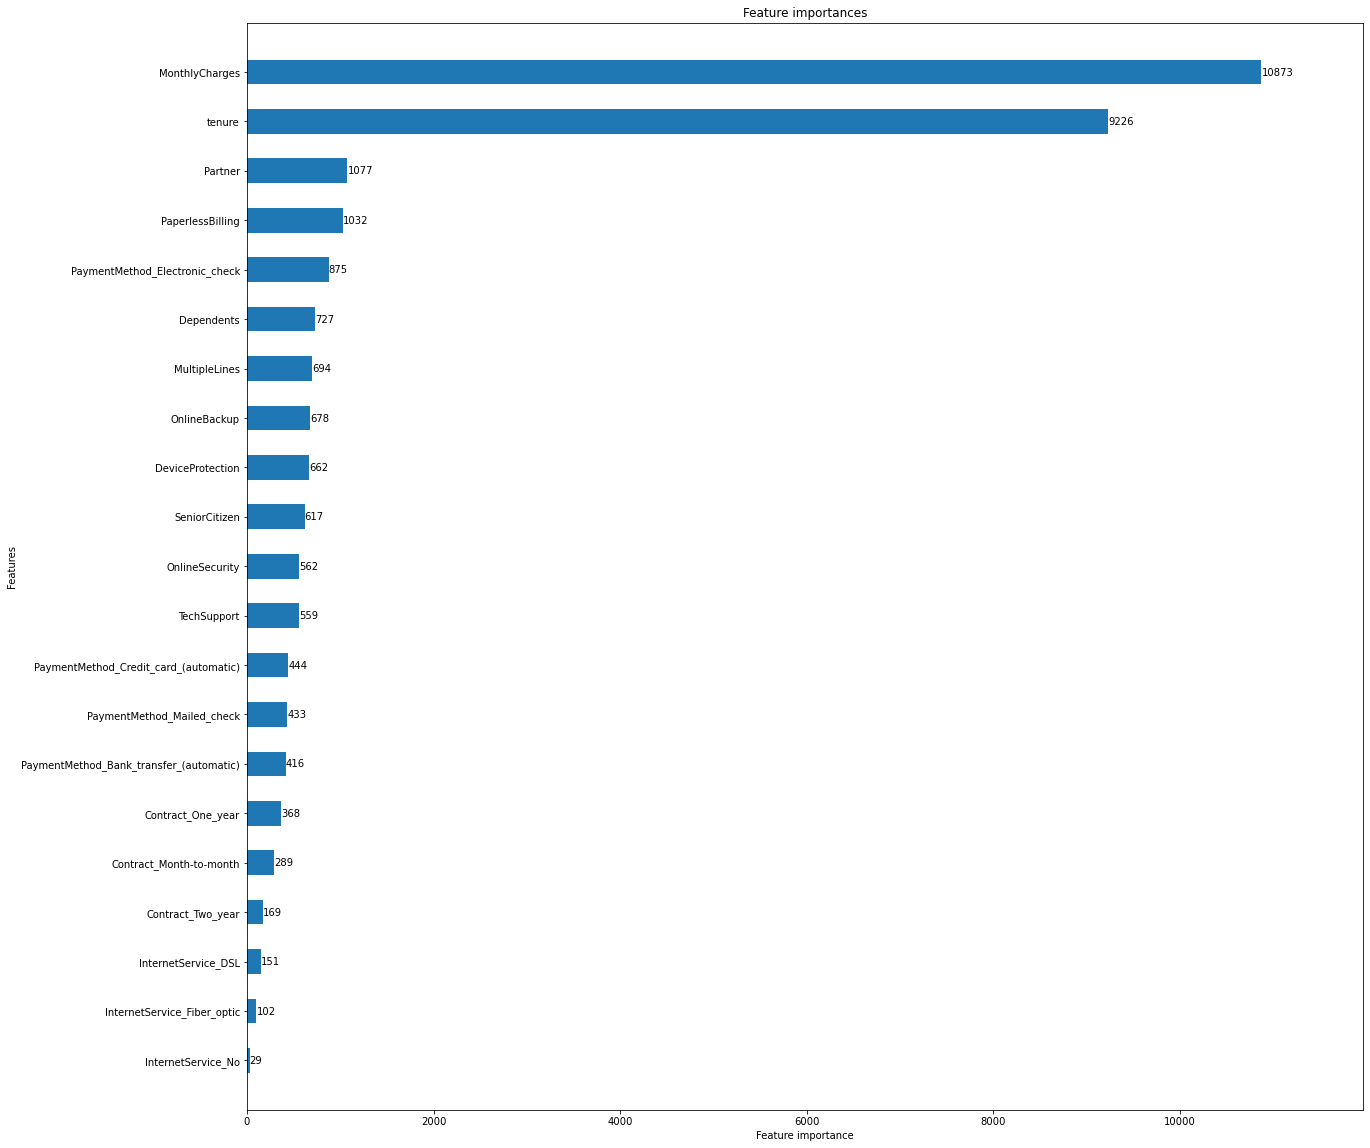

In [32]:
fig, ax = plt.subplots(figsize=(20,20))
lightgbm.plot_importance(lgb,ax=ax,height=0.5,grid=False)
plt.title("Feature importances")
plt.show()



In [33]:
# 训练好后对模型进行存储
import joblib
joblib.dump(lgb,"./models/lgb.m")
# joblib.load()

['./models/lgb.m']

# 分析与决策

## 在可视化阶段，可以发现较易流失的客户在各个特征的用户画像如下：

- 基本信息
- - 老年人
- - 未婚
- - 无家属
- - 入网时间不长，特别是2个月之内


- 开通业务
- - 开通光纤网络
- - 未开通在线安全、在线备份、设备保护、技术支持等互联网增值业务


- 签订合约
- - 合约期限较短，特别是逐月付费客户最易流失
- - 采用电子结算（多为按月支付）
- - 采用电子支票
- - 每月费用较高，特别是70～110之间
- - 总费用较低（侧面反应入网时间较短）



- 根据用户画像，可以从各个方面推出相应活动以求留下可能流失的客户：

- - 对老人推出亲情套餐等优惠
- - 对未婚、无家属的客户推出暖心套餐等优惠
- - 对新入网用户提供一定时期的优惠活动，直至客户到达稳定期
- - 提高电话服务、光纤网络、网络电视、网络电影等的客户体验，尝试提高用户的留存率，避免客户流失
- - 对能够帮助客户留存的在线安全、在线备份、设备保护、技术支持等互联网增值业务，加大宣传推广力度
- - 对逐月付费用户推出年费优惠活动
- - 对使用电子结算、电子支票的客户，推出其他支付方式的优惠活动
- - 对每月费用在70～110之间推出一定的优惠活动

## 在模型预测阶段，可以结合预测出的概率值决定对哪些客户进行重点留存：

In [34]:
# 加载前面处理好的数据
data = pd.read_csv("./processed_data/processed_data.csv")
print(data.shape)
print(data["Churn"].value_counts())
data.head()

(7043, 22)
0    5174
1    1869
Name: Churn, dtype: int64


,SeniorCitizen,Partner,Dependents,tenure,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,PaperlessBilling,MonthlyCharges,InternetService_DSL,InternetService_Fiber optic,InternetService_No,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn
0,0,1,0,-1.28,0,0,1,0,0,1,-1.16,1,0,0,1,0,0,0,0,1,0,0
1,0,0,0,0.07,0,1,0,1,0,0,-0.26,1,0,0,0,1,0,0,0,0,1,0
2,0,0,0,-1.24,0,1,1,0,0,1,-0.36,1,0,0,1,0,0,0,0,0,1,1
3,0,0,0,0.51,0,1,0,1,1,0,-0.75,1,0,0,0,1,0,1,0,0,0,0
4,0,0,0,-1.24,0,0,0,0,0,1,0.20,0,1,0,1,0,0,0,0,1,0,1


In [35]:
X,Y = data.iloc[:,:-1],data.iloc[:,-1]
pred_prob = lgb.predict_proba(X)
pred_prob = np.round(pred_prob, 1) # 对预测出的概率值保留两位小数，便于分组观察
print(pred_prob[:5])
print(Y[:5])

[[0.7 0.3]
 [1.  0. ]
 [0.1 0.9]
 [1.  0. ]
 [0.3 0.7]]
0    0
1    0
2    1
3    0
4    1
Name: Churn, dtype: int64


In [36]:
# 合并预测值概率和真实值
probDf = pd.DataFrame(pred_prob)
churnDf = pd.DataFrame(Y)
df1 = pd.concat([probDf, churnDf], axis=1)
df1.columns = ['prob_0','prob_1', 'churn']
df1.head(10)

,prob_0,prob_1,churn
0,0.70,0.30,0
1,1.00,0.00,0
2,0.10,0.90,1
3,1.00,0.00,0
4,0.30,0.70,1
5,0.00,1.00,1
6,0.80,0.20,0
7,0.90,0.10,0
8,0.00,1.00,1
9,1.00,0.00,0


In [37]:
# 分组计算每种预测概率值所对应的真实流失率
df1.drop("prob_0",inplace=True,axis=1)
group = df1.groupby(['prob_1'])
cnt = group.count()    # 每种概率值对应的样本数
true_prob = group.sum() / group.count()    # 真实流失率
df2 = pd.concat([cnt,true_prob], axis=1).reset_index()
df2.columns = ['prob_1', 'cnt', 'true_prob']
df2

,prob_1,cnt,true_prob
0,0.00,3402,0.00
1,0.10,869,0.02
2,0.20,328,0.04
3,0.30,182,0.07
4,0.40,147,0.19
5,0.50,128,0.21
6,0.60,108,0.46
7,0.70,157,0.72
8,0.80,308,0.82
9,0.90,723,0.93


由表可知：预测流失率越大的客户中越有可能真正发生流失。对运营商而言，可以根据各预测概率值分组的真实流失率设定阈值进行决策。例如，假设阈值为true_prob = 0.5，即优先关注真正流失为50%以上的群体，也就表示运营商可以对预测结果中大于等于0.6的客户进行重点留存。

In [38]:
# todo:
